# End-to-End Machine Learning Project

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

## Fetching and loading data from a url

In [5]:
# imports required for fetching and loading data

from pathlib import Path
import tarfile
import urllib.request

### Downloading the data

In [7]:
# defining a function to fetch and load data

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz") # creates a Path object representing the location of the file inside a datasets folder
    
    if not tarball_path.is_file(): # checks if tarball_path exists
        Path("datasets").mkdir(parents=True, exist_ok=True) # creates datasets library if it doesn't already exist; exist_ok=True ensures no error occurs if datasets already exists
        
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path) # downloads the .tgz file from the url and saves it in tarball_path
        
        with tarfile.open(tarball_path) as housing_tarball: # it opens the .tgz file for extraction; with makes sure the file is properly closed after extraction
            housing_tarball.extractall(path="datasets") # extracts data from .tgz file and stores it in folder 'datasets'
    
    return pd.read_csv(Path("datasets/housing/housing.csv")) # returns the .csv file as a dataframe

In [8]:
housing = load_housing_data() # loading the data

### Taking a quick look at the dataframe

In [10]:
housing.head() # shows the top 5 rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [11]:
housing.info() # used to get a description of the data (total rows, type, and number of non-null values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


`total_bedrooms` attribute has only 20433 non-null values, meaning that 207 districts are missing this feature. This will be dealt with later.

All attributes are numerical, except for `ocean_proximity` and this attribute is repetitive which means that it is probably a categorical attribute.

In [13]:
housing["ocean_proximity"].value_counts() # returns the different categories and how many districts belong to each category

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [14]:
housing.describe() # shows the summary of numerical attributes in the data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Can also get a feel for the data by plotting on a graph using the matplotlib or seaborn library

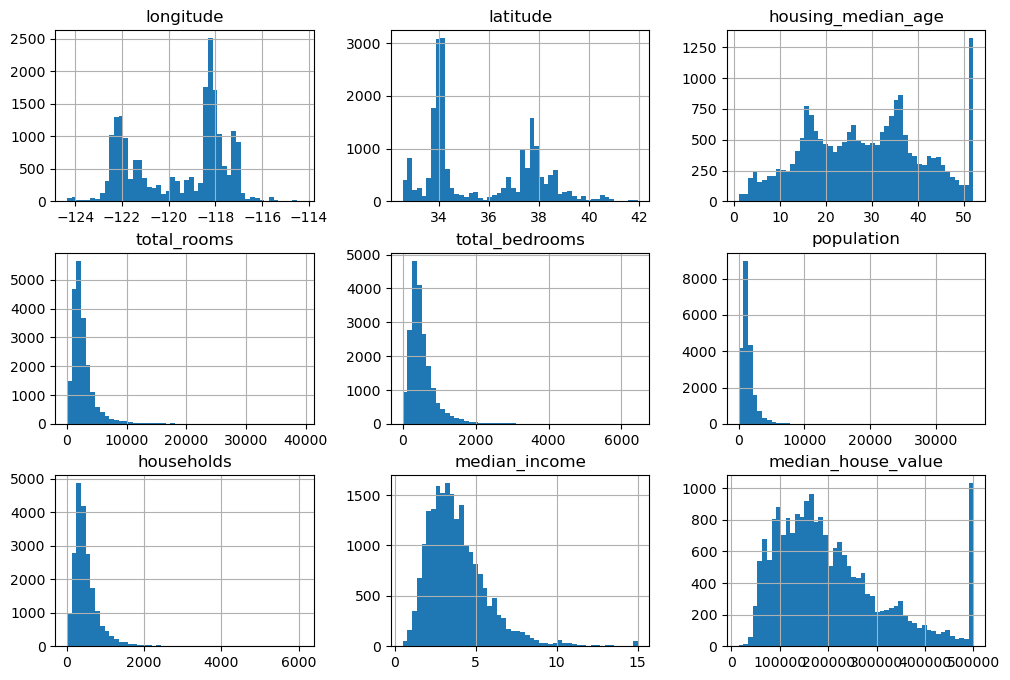

In [16]:
# plotting the data

housing.hist(bins=50, figsize=(12, 8)) 
plt.show()

Few things to notice about the graphs:
- The `median_income` attribute has been scaled and capped to 15 (actually, 15.00001) for higher median incomes and, and at 0.5 for lower median houses. The numbers represent roughly tens of thousands of dollars.
- The `housing_median_age` and `median_house_value` were also capped. The latter may be a serious problem since it is the target attribute. The algorithm may learn that prices **never** go beyond that limit. If precise predictions even beyond $500,000 is needed, then there's two options:
  - Collect proper labels for the districts whose labels were capped
  - Remove those districts from the training set (and also from the test set)
- Finally, many histograms are *skewed* right. This may make it harder for some ml algorithms to detect patterns

### Creating a Test Set

It is important for the training and testing set to contain data that is representative of the population. The `median_income` attribute is very important in predicting the median_house_value.

Looking at the graph plotted above, it can be seen that the majority lies between 1.5 and 6 ($15,000 to $60,000), but some median incomes go far beyond 6.

Therefore, to get a test set that is representative of the population, stratified sampling must be performed. Since the median income is a continuous numerical attribute, we must first create a income category attribute. This can be done using `pd.cut()`

In [20]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])

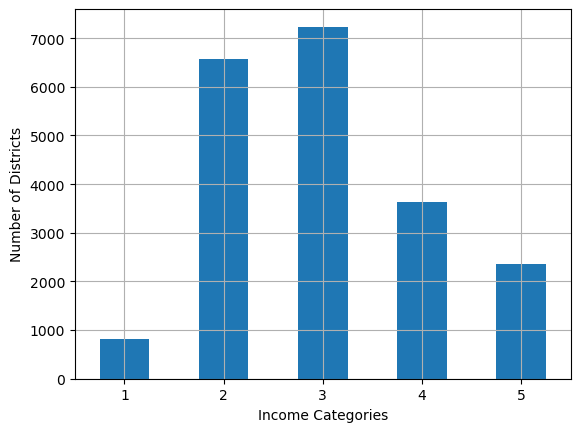

In [21]:
# plotting the newly created income_cat attribute

housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income Categories")
plt.ylabel("Number of Districts")
plt.show()

Scikit Learn provides a number of splitter classes in the `sklearn.model_selection` package that implement various strategies to split the dataset into a training set and test set. Each splitter has a `split()` method that returns an iterator over different training/test splits of the same data.

To be precise, the `split()` method yields the training and test indices, not the data itself. Having multiple splits can be useful if you want to better estimate the performance of the model. The following code generates 10 different startified splits of the same dataset.

In [23]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

strat_splits = []

for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

You could either set the train and test set to the 0th index of `strat_splits[]` or get a single split using sklearn

In [25]:
from sklearn.model_selection import train_test_split

strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

In [26]:
strat_test_set["income_cat"].value_counts()/len(strat_test_set) # checking if stratified sampling worked

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [27]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Exploring and Visualizing the Data to Gain Insights

In [29]:
housing_train = strat_train_set.copy() # making a copy so that any transformations made don't affect the original data

### Visualizing Geographical Data

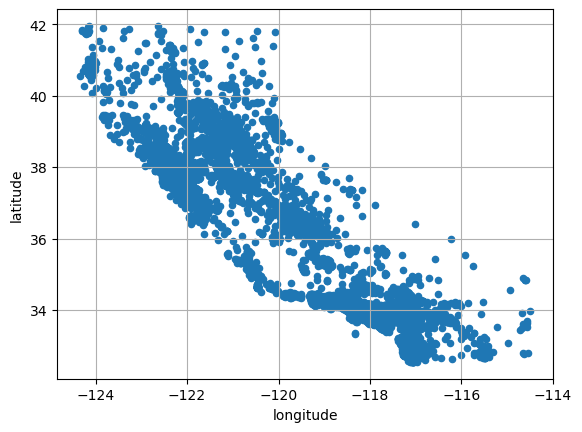

In [31]:
housing_train.plot(kind="scatter", x="longitude", y="latitude", grid=True)
plt.show()

It's pretty hard to notice any patterns with this

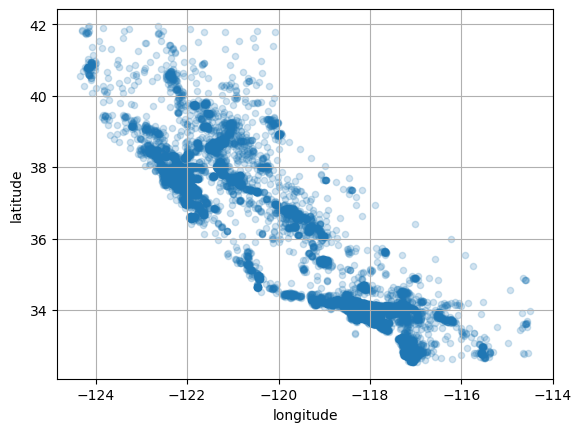

In [33]:
housing_train.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2) # reducing alpha to see more patterns
plt.show()

This is good, we can see all the high density areas. Let's look at a plot of the housing prices

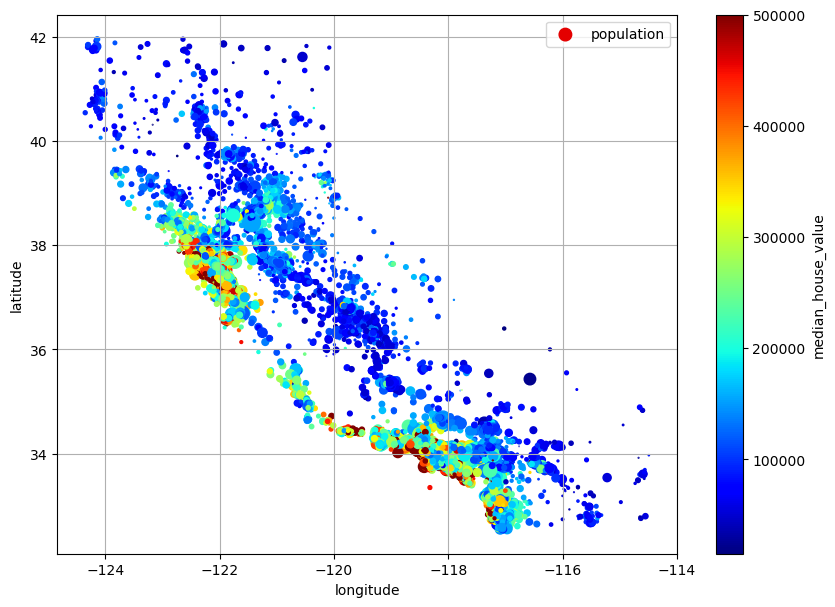

In [35]:
housing_train.plot(kind="scatter", x="longitude", y="latitude", grid=True, s=housing_train["population"]/100, label="population", c="median_house_value", cmap="jet", colorbar=True, legend=True, sharex=False, figsize=(10,7))
plt.show()

Few things about the plot:
- the radius of each circle represents the district's population (option s)
- the color represents the price (option c)
- a predefined color map called 'jet' is used which ranges from blue (low values) to red (high values)

What we can learn from the plot:
- the housing prices are very much related to the location of (eg., close to the ocean)
- they are also very much related to the population density

What can we do after understanding this data?
- It tells us that a clustering algorithm should be useful for detecting the main cluster and for adding new features that measure proximity to the cluster centers

### Looking for Correlations

Since the dataset is not too large, you can easily compute the *standard correlation coefficient* between every pair of attributes using the `corr()` method

corr_matrix = housing_train.corr(numeric_only=True) # ignores the categorical feature

In [44]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

Another way to check for correlation between attributes is to use the Pandas `scatter_matrix()` function, which plots every numerical attribute against every other numerical attribute. Let's focus on the few promising attributes that seem the most correlated with the median housing value

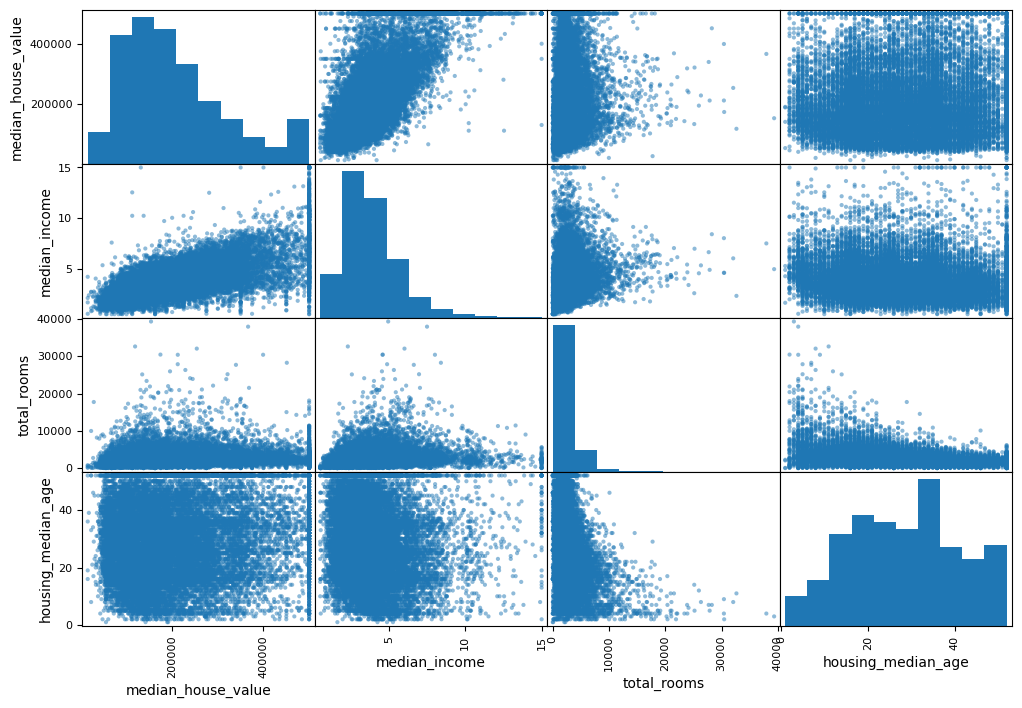

In [47]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))

plt.show()

Most promising attribute seeems to be the median_income

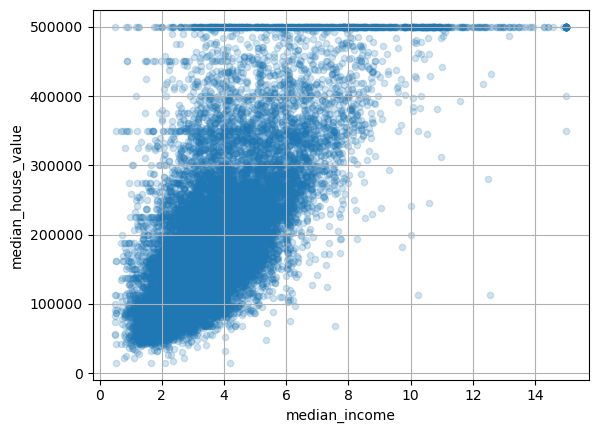

In [54]:
# zooming in on the scatter plot for the most promising attribute
housing_train.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.2, grid=True)
plt.show()

The plot reveals:
- the correlation is quite strong
- the price cap at $500,000 is clearly visible
- there are horizontal lines at many places

We may want to remove those districts to prevent the machine learning algorithm from learning to reproduce these data quirks